##Prototypes for SSO metrics and plots. ##

This notebook assumes you have downloaded or generated some files which contain the orbits for a set of SSOs and the observations of each SSO (in a particular opsim run) coupled with the opsim values for each visit. When this gets into "MAF proper", the columns for the opsim visits should be computed automatically from the list of metrics; for now, the opsim values provided for each visit are 

> expMJD night fieldRA fieldDec (radians) filter rotSkyPos seeing fiveSigmaDepth  

and the values for each SSO are 

> ObjID ra dec (degrees) dra/dt ddec/dt distance Vmag (assumes H=20 if H not specified) dmagColor (to convert to the filter) dmagTrailing (based on velocity)
    
Some sample files are available at http://www.astro.washington.edu/users/lynnej/sso/ for MBAs, TNOs and PHAs.
For each of these sets of files, the orbits file either has no suffix (and is a subset of objects from the S3M model) or ends with .des (for a pha sample, of the largest NEOs from the MPC). 
The observation files (ending with `_allObs.txt`) are created by the [proto_make_obs.py](https://github.com/rhiannonlynne/MafSSO/blob/master/proto_make_obs.py) script or a slightly modified version [here](https://github.com/rhiannonlynne/MafSSO/blob/master/proto_make_obs2.py) (for S3M input files).

---
Read in the orbits and observations. We're not using maf modules here yet, because these metrics are not yet integrated into the framework. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
#orbitfile = 'mbas_1000.txt'
#orbitfile = 'tnos_1000.txt'
orbitfile = 'pha20141031.des'
outroot = orbitfile.replace('.des', '').replace('.txt', '')
obsfile = outroot + '_allObs.txt'

orbits = pd.read_table(orbitfile, sep='\s*', engine='python')
orbits = orbits.to_records()

obs = pd.read_table(obsfile, sep='\s*', engine='python')
obs = obs.to_records()

Let's make two example metrics, for the number of observations of each object and for the number of discovery chances.

> note to make this easier for new metrics: move the H mag loop out from the individual metrics to the 'over each object' loop. Then calculate mags & SNR (& mag error and astrometry error?) there, and pass to each metric along with ssoObs). Let each metric calculate 'visibility' though, as may have different snrLimit.  Although - consider what happens if each object has a given H magnitude (which is different from orbit to orbit)

In [4]:
def nObsMetric(ssoObs, magH=20., Hrange=np.arange(13, 27, 0.25), snrLimit=5):
    # Given the observations for a particular object and the opsim metadata:
    # Return the number of observations above SNR (in any band) as a function of H
    countObs = np.zeros(len(Hrange), int)
    if len(ssoObs) == 0:
        return countObs
    # Calculate the magnitude of this object in this filter, each H magnitude. 
    for i, H in enumerate(Hrange):
        magObs = H - magH + ssoObs['magV'] + ssoObs['dmagColor']
        magLimitWithTrailing = ssoObs['fiveSigmaDepth'] - ssoObs['dmagTrailing']
        snr = 5.0 * np.power(10., 0.4*(magLimitWithTrailing - magObs))
        countObs[i] = np.where(snr >= snrLimit)[0].size
    return countObs

In [5]:
def DiscoveryMetric(ssoObs, magH=20., Hrange=np.arange(13, 27, 0.25), snrLimit=5, 
                    nObsPerNight=2, nNightsPerWindow=3, window=15):
    # Given the observations for a particular object and the opsim metadata (join using joinObs)
    # Return the number possibilities for 'discovery' of the object, as a function of H
    discoveryChances = np.zeros(len(Hrange), int)
    if len(ssoObs) == 0:
        return discoveryChances
    # Calculate the magnitude of this object in this filter, each H magnitude. 
    for i, H in enumerate(Hrange):
        magObs = H - magH + ssoObs['magV'] + ssoObs['dmagColor']
        magLimitWithTrailing = ssoObs['fiveSigmaDepth'] - ssoObs['dmagTrailing']
        snr = 5.0 * np.power(10., 0.4*(magLimitWithTrailing - magObs))
        vis = np.where(snr>=snrLimit)[0]
        # more complicated function for visibility
        if len(vis) == 0:
            discoveryChances[i] = 0
        else:
            # Now to identify where observations meet the timing requirements.
            #  Identify visits where the 'night' changes. 
            nights = np.sort(ssoObs['night'][vis])
            nightChangeIdx = np.where(nights != np.roll(nights, 1))[0]
            # NightChangeIdx now points at all the nights where the night is different than the previous. 
            # Look at difference in index values: difference is number of obs that were within each night.
            #   if difference is > nObsPerNight, this is a 'good' night. Subtract 1 to point at proper night.
            moreThanXIdx = np.where(nightChangeIdx - np.roll(nightChangeIdx, 1) >= 2)[0] - 1
            # Set moreThanXIdx to be the actual values of the night array where there were more than nObsPerNight.
            moreThanXIdx = nightChangeIdx[moreThanXIdx]
            # Identify actual night values, to look at 'window' interval.
            nightsX = nights[moreThanXIdx]
            # Look at intervals between 'good' nights. 
            if len(nightsX) < nNightsPerWindow:
                discoveryChances[i] = 0
            else:
                nw = nNightsPerWindow - 1
                windowIdx = np.concatenate([np.where(nightsX[nw:2*nw] - nightsX[:nw] <= window)[0],
                                           np.where(nightsX[nw:] - nightsX[:-nw] <= window)[0],
                                           np.where(nightsX[-nw:] - nightsX[-2*nw:-nw] <= window)[0] + len(nightsX)-1-nw])
                windowIdx = np.unique(windowIdx)
                discoveryChances[i] = windowIdx.size
                #print nightsX[windowIdx]
    return discoveryChances

What is mean length of discovery arc? Is it 15 nights, or 3?

In [6]:
def SimplerPythonDiscoveryMetric(ssoObs, magH=20., Hrange=np.arange(13, 27, 0.25), snrLimit=5, 
                                 nObsPerNight=2, nNightsPerWindow=3, window=15):
    # Given the observations for a particular object and the opsim metadata (join using joinObs)
    # Return the number possibilities for 'discovery' of the object, as a function of H
    # This is the same (almost - misses the last discovery chance) as above, but much slower. Maybe easier to read.
    discoveryChances = np.zeros(len(Hrange), int)
    if len(ssoObs) == 0:
        return discoveryChances
    # Calculate the magnitude of this object in this filter, each H magnitude. 
    for i, H in enumerate(Hrange):
        magObs = H - magH + ssoObs['magV'] + ssoObs['dmagColor']
        magLimitWithTrailing = ssoObs['fiveSigmaDepth'] - ssoObs['dmagTrailing']
        snr = 5.0 * np.power(10., 0.4*(magLimitWithTrailing - magObs))
        vis = np.where(snr>=snrLimit)[0]
        if len(vis) == 0:
            discoveryChances[i] = 0
        else:
            nightsWithEnoughObs = []
            nights = np.unique(ssoObs['night'][vis])
            tmp = []
            for n in nights:
                nobsNight = np.where(ssoObs['night'][vis] == n)[0].size
                if nobsNight >= nObsPerNight:
                    nightsWithEnoughObs.append(n)
            nightsWithEnoughObs = np.array(nightsWithEnoughObs)
            for n in nightsWithEnoughObs:
                deltanights = nightsWithEnoughObs - n
                windowNights = np.where((deltanights <= window) & (deltanights >= 0))[0]
                if len(windowNights) >= nNightsPerWindow:
                    discoveryChances[i] += 1
                    tmp.append(nightsWithEnoughObs[windowNights])
            #print tmp
    return discoveryChances

Define 'Completeness' as the equivalent of a summary statistic, to run on the results of 'DiscoveryChances'. 

In [7]:
def Completeness(discoveryChances, Hrange, numSsos, requiredChances=1):
    completeness = np.zeros(len(Hrange), float)
    discoveries = discoveryChances.swapaxes(0, 1)
    for i, H in enumerate(Hrange):
        completeness[i] = np.where(discoveries[i] >= requiredChances)[0].size
    completeness = completeness/float(numSsos)
    return completeness

Some examples for new metrics. 
* colors
* period recovery (2-12 hrs)
* solar elongation / phase coverage
* orbital accuracy
* ephemeris uncertainty at some point in the future (10 years?)
* detection of activity / discovery of MBAs or activity in Centaurs
    - collisions vs. surface activity? 

In [8]:
def PeriodCoverageMetric(ssoObs, magH=20., Hrange=np.arange(13, 27, 0.25), snrLimit=5,
                       periods=np.arange(2.0, 12.0, 0.5)):
    # Given the observations for a particular object and the opsim metadata:
    # Return the number of observations above SNR (in any band) as a function of H
    phaseGaps = np.ones([len(Hrange), len(periods)], float)
    if len(ssoObs) == 0:
        return phaseGaps
    # Calculate the magnitude of this object in this filter, each H magnitude. 
    for i, H in enumerate(Hrange):
        magObs = H - magH + ssoObs['magV'] + ssoObs['dmagColor']
        magLimitWithTrailing = ssoObs['fiveSigmaDepth'] - ssoObs['dmagTrailing']
        snr = 5.0 * np.power(10., 0.4*(magLimitWithTrailing - magObs))
        visObs = ssoObs[np.where(snr >= snrLimit)]
        for j, period in enumerate(periods):
            if len(visObs) <= 1:
                phaseGaps[i][j] = 1.0
                continue
            phases = (visObs['expMJD'] % period)/float(period)
            phases = np.sort(phases)
            gaps = np.diff(phases)
            start_to_end = np.array([1.0 - phases[-1] + phases[0]], float)
            gaps = np.concatenate([gaps, start_to_end])
            maxGap = np.max(gaps)
            phaseGaps[i][j] = maxGap
    return phaseGaps    

Detection of activity: MBC has active period of 6-12 months out of orbital period of 6-7 years. Want to sample the activity well, but the first step is detecting activity. Could be the result of collision or surface activity. 
* Need morphology at each detection to be able to flag activity. 
* Could potentially detect activity by increase in brightness (photometry). 
* Need to sample every few months (when it is observable) over entire orbital period for MBC for general activity
* Need to sample more frequently (weeks-months) to detect collisional activity
* For morphology; only need to see extendedness. For brightness variability; need to know expected brightness (i.e. should already be 'discovered'). 

In [9]:
def ActivityOverTimeMetric(ssoObs, magH=20., Hrange=np.arange(13, 27, 0.25), snrLimit=5, window=30.0):
    # For cometary activity, expect activity at the same point in its orbit at the same time, mostly
    # For collisions, expect activity at random times
    windowBins = np.arange(0, 10.0*365 + window/2.0, window)
    nWindows = len(windowBins)
    activityWindows = np.zeros(len(Hrange), int)
    if len(ssoObs) == 0:
        return activityWindows
    # Calculate the magnitude of this object in this filter, each H magnitude. 
    for i, H in enumerate(Hrange):
        magObs = H - magH + ssoObs['magV'] + ssoObs['dmagColor']
        magLimitWithTrailing = ssoObs['fiveSigmaDepth'] - ssoObs['dmagTrailing']
        snr = 5.0 * np.power(10., 0.4*(magLimitWithTrailing - magObs))
        vis = np.where(snr>=snrLimit)[0]
        if len(vis) == 0:
            activityWindows[i] = 0
        else:
            n, b = np.histogram(ssoObs[vis]['night'], bins=windowBins)
            activityWindows[i] = np.where(n>0)[0].size
    return activityWindows[i] / float(nWindows)

In [10]:
def ActivityOverPeriodMetric(ssoObs, orbit, magH=20., Hrange=np.arange(13, 27, 0.25), snrLimit=5, nBins=10):
    # For cometary activity, expect activity at the same point in its orbit at the same time, mostly
    # For collisions, expect activity at random times
    period = np.power(orbit['q']/(1-orbit['e']), 3/2) * 365.25
    meanAnomaly = ((ssoObs['expMJD'] - orbit['t_p']) / period) % (2*np.pi)
    binsize = 2*np.pi / float(nBins)
    anomalyBins = np.arange(0, 2*np.pi + binsize/2.0, binsize)
    activityWindows = np.zeros(len(Hrange), int)
    if len(ssoObs) == 0:
        return activityWindows
    # Calculate the magnitude of this object in this filter, each H magnitude. 
    for i, H in enumerate(Hrange):
        magObs = H - magH + ssoObs['magV'] + ssoObs['dmagColor']
        magLimitWithTrailing = ssoObs['fiveSigmaDepth'] - ssoObs['dmagTrailing']
        snr = 5.0 * np.power(10., 0.4*(magLimitWithTrailing - magObs))
        vis = np.where(snr>=snrLimit)[0]
        if len(vis) == 0:
            activityWindows[i] = 0
        else:
            n, b = np.histogram(meanAnomaly[vis], bins=anomalyBins)
            activityWindows[i] = np.where(n>0)[0].size
    return activityWindows[i] / float(nBins)

Run metrics (call the metric once for each object, passing all observations). 

In [11]:
ssoID = '!!ObjID'
ssoID_orbit = ssoID
if ssoID_orbit not in orbits.dtype.names:
    ssoID_orbit = '!!OID'

ssoids = orbits[ssoID_orbit]
if len(ssoids) != len(np.unique(orbits[ssoID_orbit])):
    print "Orbit id's are repeated!"

In [191]:
# Set up to run metrics. 
Hrange = np.arange(10, 10.2, 0.5)
sNum = float(len(ssoids))

nobsSsos = np.zeros([len(ssoids), len(Hrange)], int)
discoveries = np.zeros([len(ssoids), len(Hrange)], int)
discoveriesSimple = np.zeros([len(ssoids), len(Hrange)], int)
completeness = np.zeros([len(ssoids), len(Hrange)], int)

periods = np.arange(2.0, 12.0, 0.5)
phaseGaps = np.zeros([len(ssoids), len(Hrange), len(periods)], float)

activityT = {}
activityP = {}
windows = [7, 14, 30, 60, 180]
nbins = [4, 6, 8, 10, 13, 16, 20]
for w in windows:
    activityT[w] = np.zeros([len(ssoids), len(Hrange)], float)
for n in nbins:
    activityP[n] = np.zeros([len(ssoids), len(Hrange)], float)
    
# Run Metrics.
for i, sso in enumerate(ssoids):
    ssoObs = obs[np.where(obs[ssoID] == sso)]
    orbit = orbits[np.where(orbits[ssoID_orbit] == sso)]
    #nobsSsos[i] = nObsMetric(ssoObs, Hrange=Hrange)
    #discoveries[i] = DiscoveryMetric(ssoObs, Hrange=Hrange, window=15)
    #discoveriesSimple[i] = SimplerPythonDiscoveryMetric(ssoObs, Hrange=Hrange, window=15)
    #phaseGaps[i] = PhaseCoverageMetric(ssoObs, Hrange=Hrange, periods=periods)
    for w in windows:
        activityT[w][i] = ActivityOverTimeMetric(ssoObs, Hrange=Hrange, window=w)
    for n in nbins:
        activityP[n][i] = ActivityOverPeriodMetric(ssoObs, orbit, Hrange=Hrange, nBins=n)
#completeness = Completeness(discoveries, Hrange, sNum)

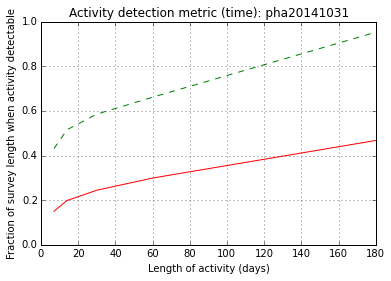

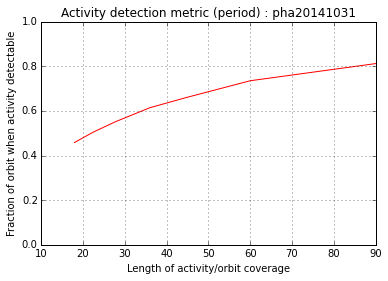

In [192]:
# Plot the min/mean/max of the fraction of activity detection opportunities, over all objects
meanFraction = np.zeros(len(windows), float)
minFraction = np.zeros(len(windows), float)
maxFraction = np.zeros(len(windows), float)

for i, w in enumerate(windows):
    meanFraction[i] = np.mean(activityT[w].swapaxes(0, 1)[0])
    minFraction[i] = np.min(activityT[w].swapaxes(0, 1)[0])
    maxFraction[i] = np.max(activityT[w].swapaxes(0, 1)[0])

plt.figure()
plt.plot(windows, meanFraction, 'r', label='Mean')
plt.plot(windows, minFraction, 'b--', label='Min')
plt.plot(windows, maxFraction, 'g--', label='Max')
plt.xlabel('Length of activity (days)')
plt.ylabel('Fraction of survey length when activity detectable')
plt.title('Activity detection metric (time): %s' %(outroot))
plt.grid()


# Plot the min/mean/max of the fraction of activity detection opportunities, over all objects
meanFraction = np.zeros(len(nbins), float)
minFraction = np.zeros(len(nbins), float)
maxFraction = np.zeros(len(nbins), float)

for i, n in enumerate(nbins):
    meanFraction[i] = np.mean(activityP[n].swapaxes(0, 1)[0])
    minFraction[i] = np.min(activityP[n].swapaxes(0, 1)[0])
    maxFraction[i] = np.max(activityP[n].swapaxes(0, 1)[0])

plt.figure()
x = 360/np.array(nbins, float)
plt.plot(x, meanFraction, 'r', label='Mean')
plt.plot(x, minFraction, 'b--', label='Min')
plt.plot(x, maxFraction, 'g--', label='Max')
plt.xlabel('Length of activity/orbit coverage')
plt.ylabel('Fraction of orbit when activity detectable')
plt.title('Activity detection metric (period) : %s' %(outroot))
plt.grid()


# to do: repeat at a range of H mags

In [12]:
# Set up to run metrics over wider range of H.
Hrange = np.arange(13, 27.2, 0.5)
sNum = float(len(ssoids))

nobsSsos = np.zeros([len(ssoids), len(Hrange)], int)
discoveries = np.zeros([len(ssoids), len(Hrange)], int)
discoveries30 = np.zeros([len(ssoids), len(Hrange)], int)
discoveriesSimple = np.zeros([len(ssoids), len(Hrange)], int)
completeness = np.zeros([len(ssoids), len(Hrange)], int)

periods = np.arange(2.0, 12.0, 0.5)
phaseGaps = np.zeros([len(ssoids), len(Hrange), len(periods)], float)

activityT = {}
activityP = {}
windows = [7, 14, 30, 60, 180]
nbins = [4, 6, 8, 10, 13, 16, 20]
for w in windows:
    activityT[w] = np.zeros([len(ssoids), len(Hrange)], float)
for n in nbins:
    activityP[n] = np.zeros([len(ssoids), len(Hrange)], float)
    
# Run Metrics.
for i, sso in enumerate(ssoids):
    ssoObs = obs[np.where(obs[ssoID] == sso)]
    orbit = orbits[np.where(orbits[ssoID_orbit] == sso)]
    nobsSsos[i] = nObsMetric(ssoObs, Hrange=Hrange)
    discoveries[i] = DiscoveryMetric(ssoObs, Hrange=Hrange, window=15)
    discoveries30[i] = DiscoveryMetric(ssoObs, Hrange=Hrange, window=30)
    #discoveriesSimple[i] = SimplerPythonDiscoveryMetric(ssoObs, Hrange=Hrange, window=15)
    #phaseGaps[i] = PhaseCoverageMetric(ssoObs, Hrange=Hrange, periods=periods)
    #for w in windows:
    #    activityT[w][i] = ActivityOverTimeMetric(ssoObs, Hrange=Hrange, window=w)
    #for n in nbins:
    #    activityP[n][i] = ActivityOverPeriodMetric(ssoObs, orbit, Hrange=Hrange, nBins=n)
completeness = Completeness(discoveries, Hrange, sNum)
completeness30 = Completeness(discoveries30, Hrange, sNum)

completeness_2 = Completeness(discoveries, Hrange, sNum, requiredChances=2)
completeness30_2 = Completeness(discoveries30, Hrange, sNum, requiredChances=2)

completeness_3 = Completeness(discoveries, Hrange, sNum, requiredChances=3)
completeness30_3 = Completeness(discoveries30, Hrange, sNum, requiredChances=3)

We may want to plot the metric results as function of H, after summing/averaging/etc. over the metric values for each individual object. 

In [13]:
def metricVsH(metricVals, Hrange, npmethod=np.mean, label='Mean', fignum=None):
    fig = plt.figure(fignum)
    if npmethod is not None:
        vals = npmethod(metricVals, axis=0)
    else:
        vals = metricVals
    plt.plot(Hrange, vals, label=label)
    plt.xlabel('H (mag)')
    return fig.number

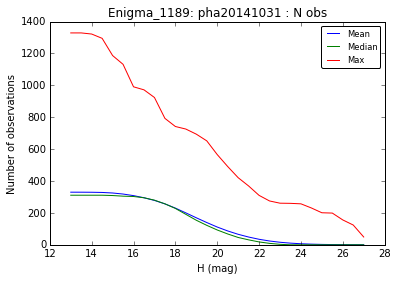

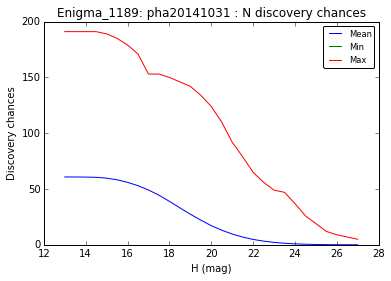

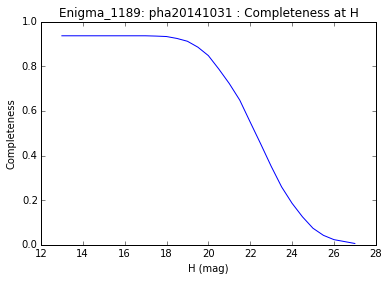

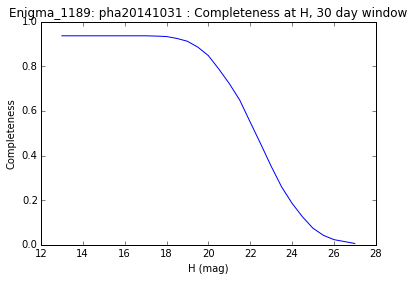

In [15]:
fignum = metricVsH(nobsSsos, Hrange)
fignum = metricVsH(nobsSsos, Hrange, np.median, label='Median', fignum=fignum)
fignum = metricVsH(nobsSsos, Hrange, np.max, label='Max', fignum=fignum)
plt.legend(fontsize='small', fancybox=True)
plt.ylabel('Number of observations')
plt.title('Enigma_1189: %s : %s' %(outroot, 'N obs'))

fignum = metricVsH(discoveries, Hrange)
fignum = metricVsH(discoveries, Hrange, np.min, label='Min', fignum=fignum)
fignum = metricVsH(discoveries, Hrange, np.max, label='Max', fignum=fignum)
plt.legend(fontsize='small', fancybox=True)
plt.ylabel('Discovery chances')
plt.title('Enigma_1189: %s : %s' %(outroot, 'N discovery chances'))

#fignum = metricVsH(discoveriesSimple, Hrange)
#fignum = metricVsH(discoveriesSimple, Hrange, np.min, label='Min', fignum=fignum)
#fignum = metricVsH(discoveriesSimple, Hrange, np.max, label='Max', fignum=fignum)
#plt.legend(fontsize='small', fancybox=True)
#plt.ylabel('Simple Discovery chances')
#plt.title('Enigma_1189: %s : %s' %(outroot, 'N discovery chances'))

fignum = metricVsH(completeness, Hrange, None)
plt.ylabel('Completeness')
plt.title('Enigma_1189: %s : %s' %(outroot, 'Completeness at H'))

fignum = metricVsH(completeness, Hrange, None)
plt.ylabel('Completeness')
plt.title('Enigma_1189: %s : %s' %(outroot, 'Completeness at H, 30 day window'))

When we interpret the above results, sometimes we want to be able to integrate over H (to give metric results at H <= X rather than just at H=X).

For the size distribution, assume a power law. 
 \begin{equation}
 dN / dH \propto 10^{\alpha \, (H-H_0)}
 \end{equation}
 
For comets, this is probably much more linear - see Colin's or Yan's paper. 

$q$ (size distribution) relates to $\alpha$

In [18]:
def integrateH(summaryVals, Hrange, Hindex=0.3):
    # Set expected H distribution. 
    # dndh = differential size distribution (number in this bin)
    dndh = np.power(10., Hindex*(Hrange-Hrange.min()))
    # dn = cumulative size distribution (number in this bin and brighter)
    dn = np.cumsum(dndh)
    intVals = np.cumsum(summaryVals*dndh)/dn
    return intVals

Completeness at H<=22 with alpha=0.3 = 70.6%
Completeness at H<=22 with alpha=0.4 = 67.3%
Completeness at H<=22 with alpha=0.5 = 64.9%


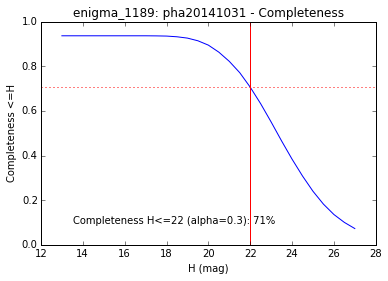

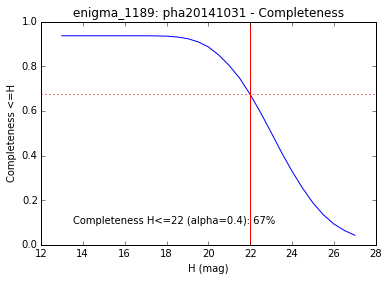

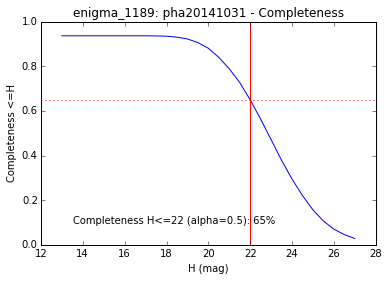

In [247]:
# Defaults.
for alpha in [0.3, 0.4, 0.5]:
    compH = integrateH(completeness, Hrange, Hindex=alpha)
    fignum = metricVsH(compH, Hrange, None)
    plt.ylabel('Completeness <=H')
    plt.title('enigma_1189: %s - %s' %(outroot, 'Completeness'))
    #completeness at H<=22
    Hidx = np.where(Hrange==22.0)[0]
    comp22 = compH[Hidx]
    plt.axhline(comp22, color='r', linestyle=':')
    plt.axvline(22, color='r')
    plt.figtext(0.2, 0.2, 'Completeness H<=22 (alpha=%.1f): %.0f%s' %(alpha, comp22*100, '%'))
    print "Completeness at H<=22 with alpha=%.1f = %.1f%s"  %(alpha, comp22*100, '%')

Completeness at H<=22 with alpha=0.3 = 73.5% (30 night window)
Completeness at H<=22 with alpha=0.4 = 70.4% (30 night window)
Completeness at H<=22 with alpha=0.5 = 68.1% (30 night window)


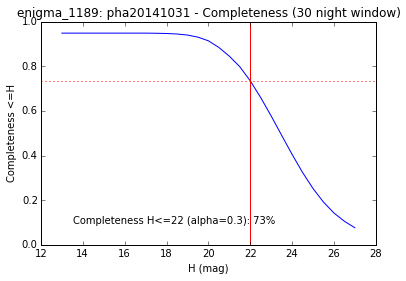

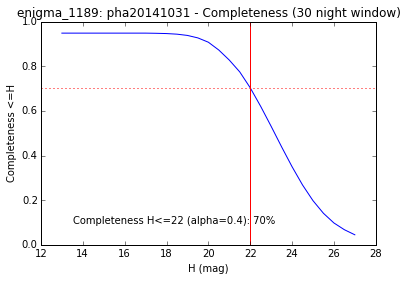

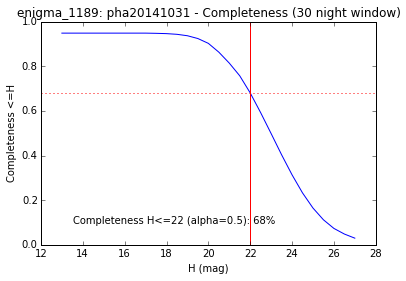

In [248]:
# Look at the difference with 30 night windows
for alpha in [0.3, 0.4, 0.5]:
    compH = integrateH(completeness30, Hrange, Hindex=alpha)
    fignum = metricVsH(compH, Hrange, None)
    plt.ylabel('Completeness <=H')
    plt.title('enigma_1189: %s - %s' %(outroot, 'Completeness (30 night window)'))
    #completeness at H<=22
    Hidx = np.where(Hrange==22.0)[0]
    comp22 = compH[Hidx]
    plt.axhline(comp22, color='r', linestyle=':')
    plt.axvline(22, color='r')
    plt.figtext(0.2, 0.2, 'Completeness H<=22 (alpha=%.1f): %.0f%s' %(alpha, comp22*100, '%'))
    print "Completeness at H<=22 with alpha=%.1f = %.1f%s (30 night window)"  %(alpha, comp22*100, '%')

Completeness at H<=22 with alpha=0.4 = 67.3%, require 1 chances
Completeness at H<=22 with alpha=0.4 = 63.6%, require 2 chances
Completeness at H<=22 with alpha=0.4 = 57.8%, require 3 chances


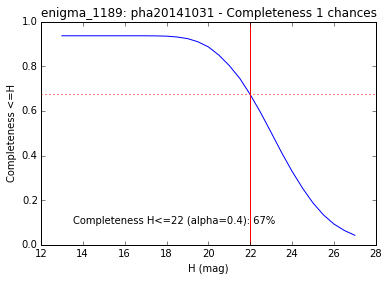

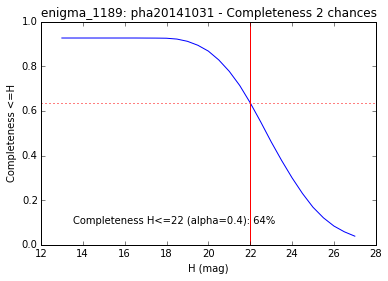

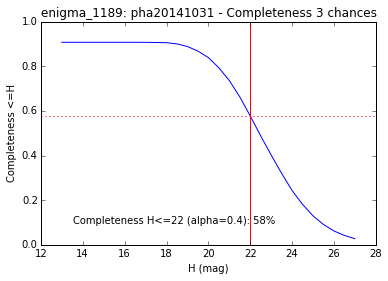

In [253]:
# Increased requirement of discovery chances (in case we lose something we could have discovered)
alpha = 0.4
for i, c in enumerate([completeness, completeness_2, completeness_3]):
    compH = integrateH(c, Hrange, Hindex=alpha)
    fignum = metricVsH(compH, Hrange, None)
    plt.ylabel('Completeness <=H')
    plt.title('enigma_1189: %s - %s' %(outroot, 'Completeness %d chances' %(i+1)))
    #completeness at H<=22
    Hidx = np.where(Hrange==22.0)[0]
    comp22 = compH[Hidx]
    plt.axhline(comp22, color='r', linestyle=':')
    plt.axvline(22, color='r')
    plt.figtext(0.2, 0.2, 'Completeness H<=22 (alpha=%.1f): %.0f%s' %(alpha, comp22*100, '%'))
    print "Completeness at H<=22 with alpha=%.1f = %.1f%s, require %d chances"  %(alpha, comp22*100, '%', i+1)

Also we want to be able to generate plots of metric value vs. orbital parameters. 

In [22]:
def metricVs2dOrbits(x, y, xlabel, ylabel, 
                     metricVals, units, Hval, Hrange,
                     xbins, ybins):
    xvals = x
    yvals = y
    nxbins = len(xbins)
    nybins = len(ybins)
    xbinsize = np.mean(np.diff(xbins))
    ybinsize = np.mean(np.diff(ybins))
    xmin = np.min(xbins)
    ymin = np.min(ybins)
    # Set up to calculate summary values at each x/y binpoint. 
    summaryVals = np.zeros((nybins, nxbins), dtype='float')
    summaryNums = np.zeros((nybins, nxbins), dtype='int')
    Hidx = np.where(Hrange == Hval)[0]
    # Metrics are evaluated in the order of the orbits. 
    for i, (xi, yi) in enumerate(zip(x, y)):
        xidx = np.min([int((xi - xmin)/xbinsize), nxbins-1])
        yidx = np.min([int((yi - ymin)/ybinsize), nybins-1])
        summaryVals[yidx][xidx] += metricVals[i][Hidx]
        summaryNums[yidx][xidx] += 1
    summaryVals = np.where(summaryNums != 0, summaryVals / summaryNums, 0)
    # Create 2D x/y arrays, to match 2D counts array.
    xi, yi = np.meshgrid(xbins, ybins)
    # Plot. 
    plt.figure()
    levels = np.arange(summaryVals.min(), summaryVals.max(), (summaryVals.max() - summaryVals.min())/200.0)
    levels = np.arange(0, 30, 1)
    plt.contourf(xi, yi, summaryVals, levels, extend='max', zorder=0)
    #plt.plot(orbits[xlabel], orbits[ylabel], 'k.', markersize=2, zorder=3)
    cbar = plt.colorbar()
    cbar.set_label(units)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

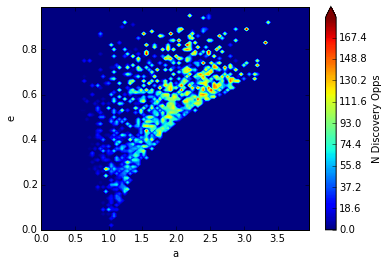

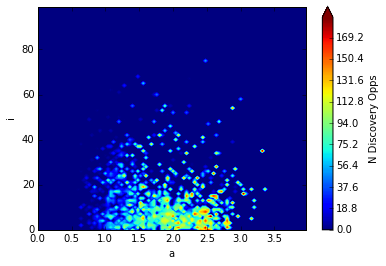

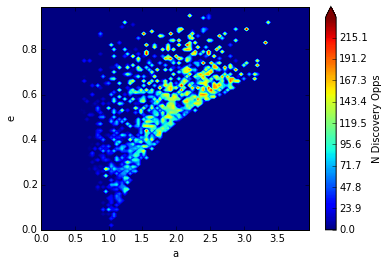

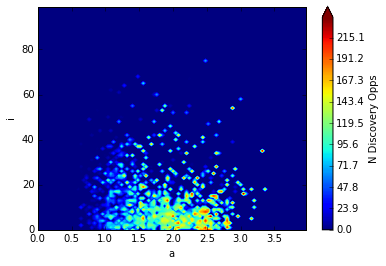

In [20]:
mag = Hrange[0]
abins = np.arange(0, 4.0, 4/100.0)
ebins = np.arange(0, 1, 0.01)
ibins = np.arange(0, 100, 1)
a = orbits['q'] / (1-orbits['e'])
metricVs2dOrbits(a, orbits['e'], 'a', 'e', discoveries, 'N Discovery Opps', mag, Hrange, abins, ebins)
metricVs2dOrbits(a, orbits['i'], 'a', 'i', discoveries, 'N Discovery Opps', mag, Hrange, abins, ibins)

mag = Hrange[0]
a = orbits['q'] / (1-orbits['e'])
metricVs2dOrbits(a, orbits['e'], 'a', 'e', discoveries30,  'N Discovery Opps', mag, Hrange, abins, ebins)
metricVs2dOrbits(a, orbits['i'], 'a', 'i', discoveries30, 'N Discovery Opps', mag, Hrange, abins, ibins)

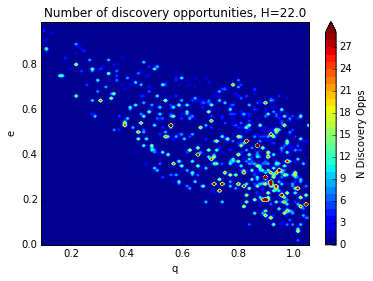

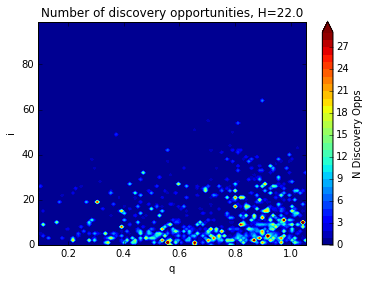

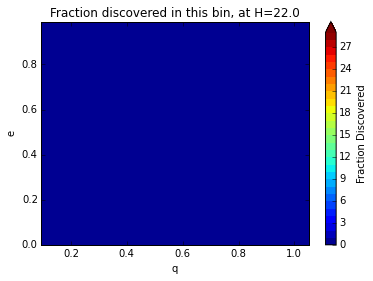

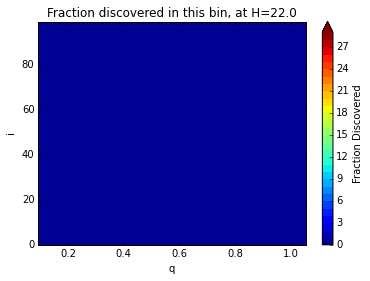

In [23]:
mag = 22
abins = np.arange(0, 4.0, 4/100.0)
qbins = np.arange(orbits['q'].min(), orbits['q'].max(), (orbits['q'].max() - orbits['q'].min())/100.0)
ebins = np.arange(0, 1, 0.01)
ibins = np.arange(0, 100, 1)
a = orbits['q'] / (1-orbits['e'])
metricVs2dOrbits(orbits['q'], orbits['e'], 'q', 'e', discoveries, 'N Discovery Opps', mag, Hrange, qbins, ebins)
plt.title('Number of discovery opportunities, H=%.1f' %(mag))
metricVs2dOrbits(orbits['q'], orbits['i'], 'q', 'i', discoveries, 'N Discovery Opps', mag, Hrange, qbins, ibins)
plt.title('Number of discovery opportunities, H=%.1f' %(mag))

a = orbits['q'] / (1-orbits['e'])
df = np.zeros([len(ssoids), len(Hrange)], float)
df = np.where(discoveries > 1, 1, 0)
metricVs2dOrbits(orbits['q'], orbits['e'], 'q', 'e', df, 'Fraction Discovered', mag, Hrange, qbins, ebins)
plt.title('Fraction discovered in this bin, at H=%.1f' %(mag))
metricVs2dOrbits(orbits['q'], orbits['i'], 'q', 'i', df, 'Fraction Discovered', mag, Hrange, qbins, ibins)
plt.title('Fraction discovered in this bin, at H=%.1f' %(mag))

In [243]:
from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection

def metricVs2dOrbitsPoints(orbits, xlabel, ylabel, metricVals, Hval, Hrange, 
                           foregroundPoints=True, backgroundPoints=True):
    x = orbits[xlabel]
    y = orbits[ylabel]    
    Hidx = np.where(Hrange == Hval)[0]
    plt.figure()
    colors = np.swapaxes(metricVals, 0, 1)[Hidx][0]
    vmin = np.max(1, colors.min())
    if backgroundPoints:
        condition = np.where(colors == 0)
        plt.plot(x[condition], y[condition], 'r.', markersize=4, alpha=0.5, zorder=3)
    if foregroundPoints:
        plt.scatter(x, y, c=colors, vmin=vmin, s=15, alpha=0.8, zorder=0)
        cb = plt.colorbar()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

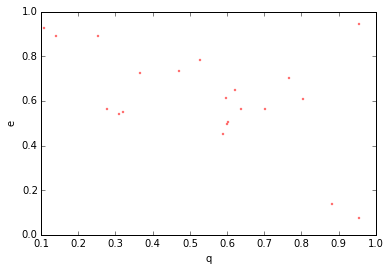

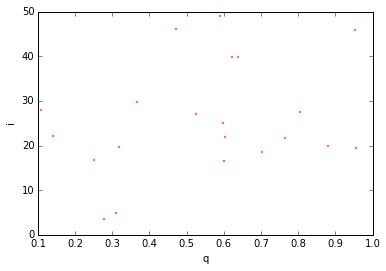

In [244]:
metricVs2dOrbitsPoints(orbits, 'q', 'e', nobsSsos, mag, Hrange, foregroundPoints=False)
metricVs2dOrbitsPoints(orbits, 'q', 'i', nobsSsos, mag, Hrange, foregroundPoints=False)